Shapes:
Patch embeddings: torch.Size([1, 3, 49, 768])
Text embeddings: torch.Size([1, 3, 18, 512])
Target IDs: torch.Size([1, 3, 18])
Mask: torch.Size([1, 3, 18])

Total sequence length: 67
Number of image patches: 49
Number of text tokens: 18


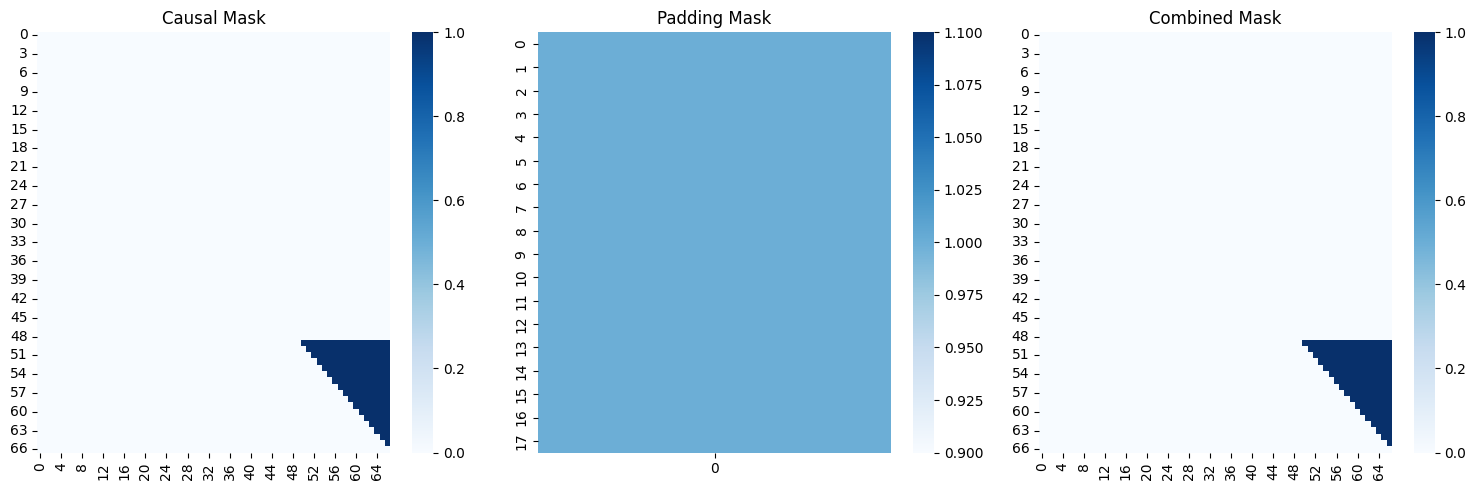

Number of padding tokens: 7


In [10]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
from load_data import CaptionDataset

# Load dataset and create train/test split
raw_dataset = load_dataset("nlphuji/flickr30k", split='test[:5000]')
train_test_split = raw_dataset.train_test_split(test_size=0.3)

# Create datasets
train_dataset = CaptionDataset(train_test_split['train'])
test_dataset = CaptionDataset(train_test_split['test'])

# Create dataloader
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=1,  # Use batch size 1 for visualization
    shuffle=True, 
    num_workers=4,
    pin_memory=True,
    multiprocessing_context='spawn'
)

def visualize_masks_for_batch(patch_embeddings, text_embeddings, target_ids, mask):
    # Print shapes first to debug
    print("Shapes:")
    print(f"Patch embeddings: {patch_embeddings.shape}")
    print(f"Text embeddings: {text_embeddings.shape}")
    print(f"Target IDs: {target_ids.shape}")
    print(f"Mask: {mask.shape}")
    
    # Get sequence lengths
    num_image_patches = 49  # CLIP ViT-B/32 has 49 patches
    text_length = text_embeddings.size(2)  # This is 18
    total_length = num_image_patches + text_length  # This is 67
    
    print(f"\nTotal sequence length: {total_length}")
    print(f"Number of image patches: {num_image_patches}")
    print(f"Number of text tokens: {text_length}")
    
    # Create causal mask
    causal_mask = torch.zeros(total_length, total_length)
    text_start_idx = num_image_patches
    
    # Create causal mask for text portion only
    text_mask = torch.triu(torch.ones(text_length, text_length), diagonal=1)
    text_mask = text_mask.masked_fill(text_mask==1, float('-inf'))
    
    # Place the text mask in the bottom-right corner
    causal_mask[text_start_idx:, text_start_idx:] = text_mask
    
    # Convert -inf to 1 for better visualization
    causal_mask = (causal_mask == float('-inf')).float()
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot causal mask
    sns.heatmap(causal_mask, ax=ax1, cmap='Blues')
    ax1.set_title('Causal Mask')
    
    # Plot padding mask
    # Reshape mask to match text length
    padding_mask = mask[0, 0].reshape(-1, 1)  # Reshape to [18, 1]
    sns.heatmap(padding_mask, ax=ax2, cmap='Blues')
    ax2.set_title('Padding Mask')
    
    # Plot combined mask
    combined_mask = torch.zeros(total_length, total_length)


    # Convert masks to boolean before combining
    causal_bool = causal_mask[text_start_idx:, text_start_idx:].bool()
    padding_bool = (mask[0, 0] == 0).bool()

    # Image portion is all zeros (can attend to everything)
    # Text portion has both causal and padding masks
    combined_mask[text_start_idx:, text_start_idx:] = (causal_bool | padding_bool).float()
    sns.heatmap(combined_mask, ax=ax3, cmap='Blues')
    ax3.set_title('Combined Mask')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional info
    print(f"Number of padding tokens: {torch.sum(mask == 0).item()}")

# Get a single batch and visualize
batch = next(iter(train_dataloader))
patch_embeddings, text_embeddings, target_ids, mask = batch
visualize_masks_for_batch(patch_embeddings, text_embeddings, target_ids, mask)